![title](spotify.png)

In [1]:
import requests
from tqdm.notebook import tqdm
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time 
import pickle
import os 
import datetime
import seaborn as sns
from sklearn.neighbors import KDTree
import random


client_id = #### Insert client ID
client_secret = #### Insert secret
token = ### Insert token

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def getTrackIDs(user,playlist_id,i):
    ids = []
    playlist = sp.user_playlist_tracks(user,playlist_id, fields=None, limit=100, offset=i, market=None)
    for n in range(len(playlist['items'])):
        track = playlist['items'][n]['track']['id']
        ids.append(track)
    return ids

def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)
    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    track = [name, album, artist, release_date, length, popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    return track

def getArtistIDs(user,playlist_id,i):
    artist_id = []
    playlist = sp.user_playlist_tracks(user,playlist_id, fields=None, limit=100, offset=i, market=None)
    for n in range(len(playlist['items'])):
        id_a = playlist['items'][n]['track']['artists'][0]['id']
        if id_a != None : 
            artist_id.append(id_a)
    return list(dict.fromkeys(artist_id))

def get_related_artists(user,playlist):
    artist_id = []
    for i in range(0, 1000, 100):
        new_ids = getArtistIDs(user,playlist,i)
        artist_id.extend(new_ids)
        time.sleep(0.2)
    
    
    related_artist_ids = []
    for ra in tqdm(artist_id):
        related_artist = sp.artist_related_artists(ra)
        for mra in range(len(related_artist['artists'])):
            rel_art = related_artist['artists'][mra]['id']
            if rel_art != None: 
                related_artist_ids.append(rel_art)
    return list(dict.fromkeys(related_artist_ids))

def all_album_songs(artist_id):
    album_ids = []
    song_ids = []
    for a in tqdm(list(artist_id)):
        artist = sp.artist_albums(a)
        for alb in range(len(artist['items'])):
            album_ids.append(artist['items'][alb]['id'])
        time.sleep(0.2)
            
    for alb in tqdm(album_ids):
        song = sp.album_tracks(alb)
        for s in range(len(song['items'])):
            song_id = song['items'][s]['id']
            song_ids.append(song_id)
        time.sleep(0.2)
    return list(dict.fromkeys(song_ids))

def One_Song_Recommender(x=0,i=0):
    list_givern = []
    from IPython.display import clear_output
    from difflib import get_close_matches
    list_of_available_songs = [df_clusters.song[i].lower() for i in range(len(df_clusters))]
    cluster_number = 999
    while True:
        if x == 0:
            song_input = input("please enter a song : ")
        else:
            song_input = x
        song_input = song_input.lower()
        closest_match = get_close_matches(song_input,list_of_available_songs)
        if len(closest_match) !=0:
            song_input = closest_match[0]
        if song_input in list_of_available_songs:
            artist_requested = df_clusters[df_clusters.song.str.lower() == song_input]['artist'].iloc[0]
            if cluster_number == 999:
                cluster_number = df_clusters[df_clusters.song.str.lower() == song_input]['cluster'].iloc[0]
            next_df = df_clusters[df_clusters.cluster == cluster_number].reset_index()
            index_last_song = next_df[next_df.song.str.lower() == song_input]['artist'].index

            list_givern.append([song_input,artist_requested])
            
            while True:
                artist,song,index_last_song = random_selector(cluster_number,index_last_song,next_df)
                if (artist == artist_requested) and (song_input == song):
                    continue
                else:
                    break
            if i == 0:
                print('')
                print('The closest matching song is: ','%.30s' %song_input.title(),'    by:    ','%.30s' %artist_requested)
                print('-----------------------------------------------------------------------------')
            False
            return song.title(), artist.title()
        
        else:
            clear_output(wait=True)
            print('Please enter valid song!')
            print("")
            cluster_number = int(df_clusters.cluster.sample())
            artist,song,_ = random_selector(cluster_number,[0],df_clusters)
            print('Example: ',song.title(),'by',artist)
            cluster_number = int(df_clusters.cluster.sample())
            artist,song,_ = random_selector(cluster_number,[0],df_clusters)
            print('OR     : ',song.title(),'by',artist)
            cluster_number = int(df_clusters.cluster.sample())
            artist,song,_ = random_selector(cluster_number,[0],df_clusters)
            print('OR     : ',song.title(),'by',artist)
     
            
def random_selector(cluster_number,index_last_song,next_df):
    from sklearn.neighbors import KDTree
    next_df_cols = next_df[df_train.columns]    
    tree = KDTree(next_df_cols, leaf_size=2)              
    dist, ind = tree.query([next_df_cols.iloc[index_last_song[0]]], k=15)    
    random_next_index = random.choice(ind[0][1:])
    random_song = next_df.iloc[random_next_index]
    
    return random_song.artist, random_song.song, random_next_index

def recommendation_amount():
    from IPython.display import clear_output
    while True:
        try:
            song_number = int(input('How many songs would you like recommended?  '))      
        except ValueError:
            print("Please enter an Integer")
            clear_output(wait=True)
            continue
        else:
            return song_number
        break 

def Multiple_Song_Recommender():
    i=0
    song_number = recommendation_amount()
    song,artist = One_Song_Recommender()
    i=1
    check_doubles = [[song,artist]]
    while i <= song_number:
        song,artist = One_Song_Recommender(song,i)
        temp_check = [song,artist]
        if temp_check not in check_doubles:
            print(str(i),'. Next recommended Song:   ','%.30s' %song.title(),'by:  ','%.30s' %artist)
            check_doubles.append(temp_check)
            i += 1
            
    check_doubles = check_doubles[1:]       
    check_doubles = pd.DataFrame(check_doubles,columns=['song','artist'])
    check_doubles.index = check_doubles.index + 1

    return check_doubles


    

# Collecting playlists
## Fetching data on Indie Playlist

In [ ]:
artist_id = []
for i in range(0, 600, 100):
    new_ids = getArtistIDs('1155830134','46CwfzD8VHol0TWlzPwNpU',i)
    artist_id.extend(new_ids)
    time.sleep(0.2)

related_artist_list = get_related_artists('1155830134','46CwfzD8VHol0TWlzPwNpU')


artist_id.extend(related_artist_list)

print('The number of unique Artists in this playlist are: ',len(artist_id))
print('The number of related artists fromt these artists are: ',len(related_artist_list))
print('The total number of artists to be scanned are: ',len(artist_id))

In [ ]:
track_ids = all_album_songs(artist_id)
print('The number of track ids from all artists found are : ',len(track_ids))
track_ids_df = pd.DataFrame(track_ids)
#track_ids_df.to_csv('track_ids_df.csv')
#track_ids.to_csv('backup_track_ids.csv')

# Run the api for all tracks details

In [ ]:
track_ids = pd.read_csv('track_ids_df.csv')['0']

In [ ]:

# Create the DataFrame of songs
tracks = []
counter = 100
for i in tqdm(range(len(track_ids))):
    try:
        time.sleep(.1)
        track = getTrackFeatures(track_ids[i])
        if track != None:
            tracks.append(track)
            if len(tracks) > 5000:
                counter += 1
                with open('sp_list_'+str(counter)+'.pkl','wb') as file:
                    pickle.dump(tracks,file)
                tracks = []
    except:
        print("Oh no!!")
        pass

# Fetching Everything from the Pickle dump

In [80]:
total_list = []
pickle_list = [i for i in os.listdir() if i.startswith('sp_list_')]
for i in pickle_list:
    with open (i,'rb') as file:
        test = pickle.load(file)
        total_list.extend(test)
    
df_spotify = pd.DataFrame(total_list, columns = ['song', 'album', 'artist', 'release_date', 'length', 
                                             'popularity', 'acousticness', 'danceability', 'energy', 
                                             'instrumentalness', 'liveness', 'loudness', 'speechiness', 
                                             'tempo', 'time_signature'])
total_rows = len(df_spotify)
inedx_drop = df_spotify[['song','artist']].drop_duplicates().index
df_spotify = df_spotify.loc[inedx_drop]
df_spotify = df_spotify[df_spotify.artist != 'Various Artists']
print('Percentage of rows dropped: ', round((total_rows-len(df_spotify))/total_rows,2)*100,'%')
df_spotify.reset_index(drop=True)
df_spotify.head()

Percentage of rows dropped:  42.0 %


,song,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Megaplex,mea culpa,Bilderbuch,2018-12-04,281587,13,0.6220,0.783,0.672,0.000007,0.4940,-7.088,0.0401,123.037,4
1,Memory Card,mea culpa,Bilderbuch,2018-12-04,172585,10,0.0064,0.566,0.488,0.000020,0.1860,-6.564,0.0386,94.983,4
2,Checkpoint (Nie Game Over),mea culpa,Bilderbuch,2018-12-04,272188,34,0.3470,0.677,0.737,0.109000,0.6560,-6.991,0.0307,91.999,4
3,Aloe Vera,mea culpa,Bilderbuch,2018-12-04,295403,8,0.9120,0.592,0.324,0.336000,0.0859,-10.466,0.0571,81.979,4
4,Carpe/Diem,Magic Life,Bilderbuch,2017-02-17,45840,23,0.9030,0.508,0.253,0.971000,0.0791,-18.492,0.0674,122.330,4


In [81]:
# set the index of the dataset
df_spotify = df_spotify.set_index(['artist','song'])

# Convert to Datetime
df_spotify.release_date = pd.to_datetime(df_spotify.release_date)

# Calculate days since release
df_spotify['days_since_release'] = df_spotify['release_date'].apply(lambda x: (datetime.datetime.now().date()-x.date()).days)

# Drop columns
df_spotify = df_spotify.drop(columns=['album','release_date'],axis=1)
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 232966 entries, ('Bilderbuch', 'Megaplex') to ('Beat Connection', 'Reality TV')
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   length              232966 non-null  int64  
 1   popularity          232966 non-null  int64  
 2   acousticness        232966 non-null  float64
 3   danceability        232966 non-null  float64
 4   energy              232966 non-null  float64
 5   instrumentalness    232966 non-null  float64
 6   liveness            232966 non-null  float64
 7   loudness            232966 non-null  float64
 8   speechiness         232966 non-null  float64
 9   tempo               232966 non-null  float64
 10  time_signature      232966 non-null  int64  
 11  days_since_release  232966 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 29.4+ MB


# Generate the KMeans Model

In [82]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Assign df's
df_train = df_spotify
df_clusters = df_spotify

## Transform the Data

In [84]:
scaler = MinMaxScaler()
scaler.fit(df_train)
df_train_trans = scaler.transform(df_train)

## Find the K-Elbow

/Users/jeroencvlier/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/jeroencvlier/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


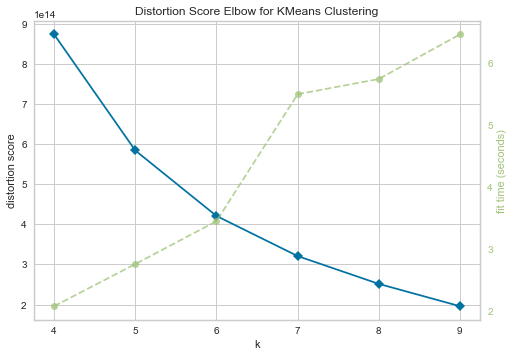

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,10))
visualizer.fit(df_train)       
visualizer.show()    
plt.show()

## Check the Silhouette Score

In [ ]:
K = range(3,10)
silhouette = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,random_state=56)
    kmeans.fit(df_train)
    silhouette.append(silhouette_score(df_train, kmeans.predict(df_train)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

## Train the model

In [85]:
# Adjust K
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_train_trans)
# Assign the Cluster
df_clusters['cluster'] = kmeans.labels_

In [86]:
# Reset Index
df_clusters = df_clusters.reset_index()

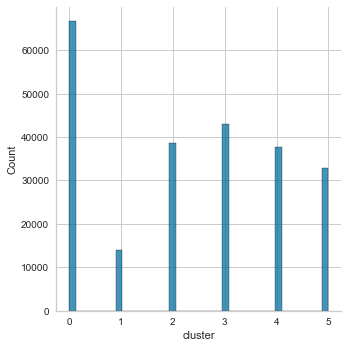

In [87]:
# Check the Distribution of clusters
sns.displot(df_clusters.cluster)
plt.show()

In [88]:
df_clusters.cluster.value_counts()

0    66648
3    43020
2    38639
4    37762
5    32837
1    14060
Name: cluster, dtype: int64

# Generate Similar Song

In [27]:
One_Song_Recommender()

Please enter valid song!

Example:  Autonomy (Live) by Buzzcocks
OR     :  Piss U Off by Tiffany
OR     :  Autonomy (Live) by Buzzcocks
please enter a song : good

The closest matching song is:  Good     by:     Alex G
-----------------------------------------------------------------------------


('Invisible', 'Minus The Bear')

# Generate Playlist

In [74]:
recommended_playlist = Multiple_Song_Recommender()

How many songs would you like recommended?  20
please enter a song : happy

The closest matching song is:  Happy     by:     On-The-Go
-----------------------------------------------------------------------------
1 . Next recommended Song:    Soon by:   Jackie Gleason
2 . Next recommended Song:    Parliament Of The Rooks by:   Mr Flash
3 . Next recommended Song:    0=100% (Party Part 2) [Konstan by:   George Fenton
4 . Next recommended Song:    Rare Candy by:   Blackbird Blackbird
5 . Next recommended Song:    Use Your Allusion I & Ii by:   Library Voices
6 . Next recommended Song:    Peterson (The American Dollar) by:   The American Dollar
7 . Next recommended Song:    Game Love by:   Django Django
8 . Next recommended Song:    Superzero Theme - Mr. Chop Rem by:   Kelpe
9 . Next recommended Song:    Out Of The Dark by:   Mr Twin Sister
10 . Next recommended Song:    Call by:   Aoki,Hayato
11 . Next recommended Song:    Vollgas by:   Rocko Schamoni
12 . Next recommended Song:    Just B

In [89]:
recommended_playlist

,song,artist
1,Soon,Jackie Gleason
2,Parliament Of The Rooks,Mr Flash
3,0=100% (Party Part 2) [Konstantine Pope Remix],George Fenton
4,Rare Candy,Blackbird Blackbird
5,Use Your Allusion I & Ii,Library Voices
6,Peterson (The American Dollar),The American Dollar
7,Game Love,Django Django
8,Superzero Theme - Mr. Chop Remix,Kelpe
9,Out Of The Dark,Mr Twin Sister
10,Call,"Aoki,Hayato"


In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_train_trans)
principalDf = pd.DataFrame(data = principalComponentsb, columns = ['principal component 1', 'principal component 2'])
principalDf['cluster'] = kmeans.labels_

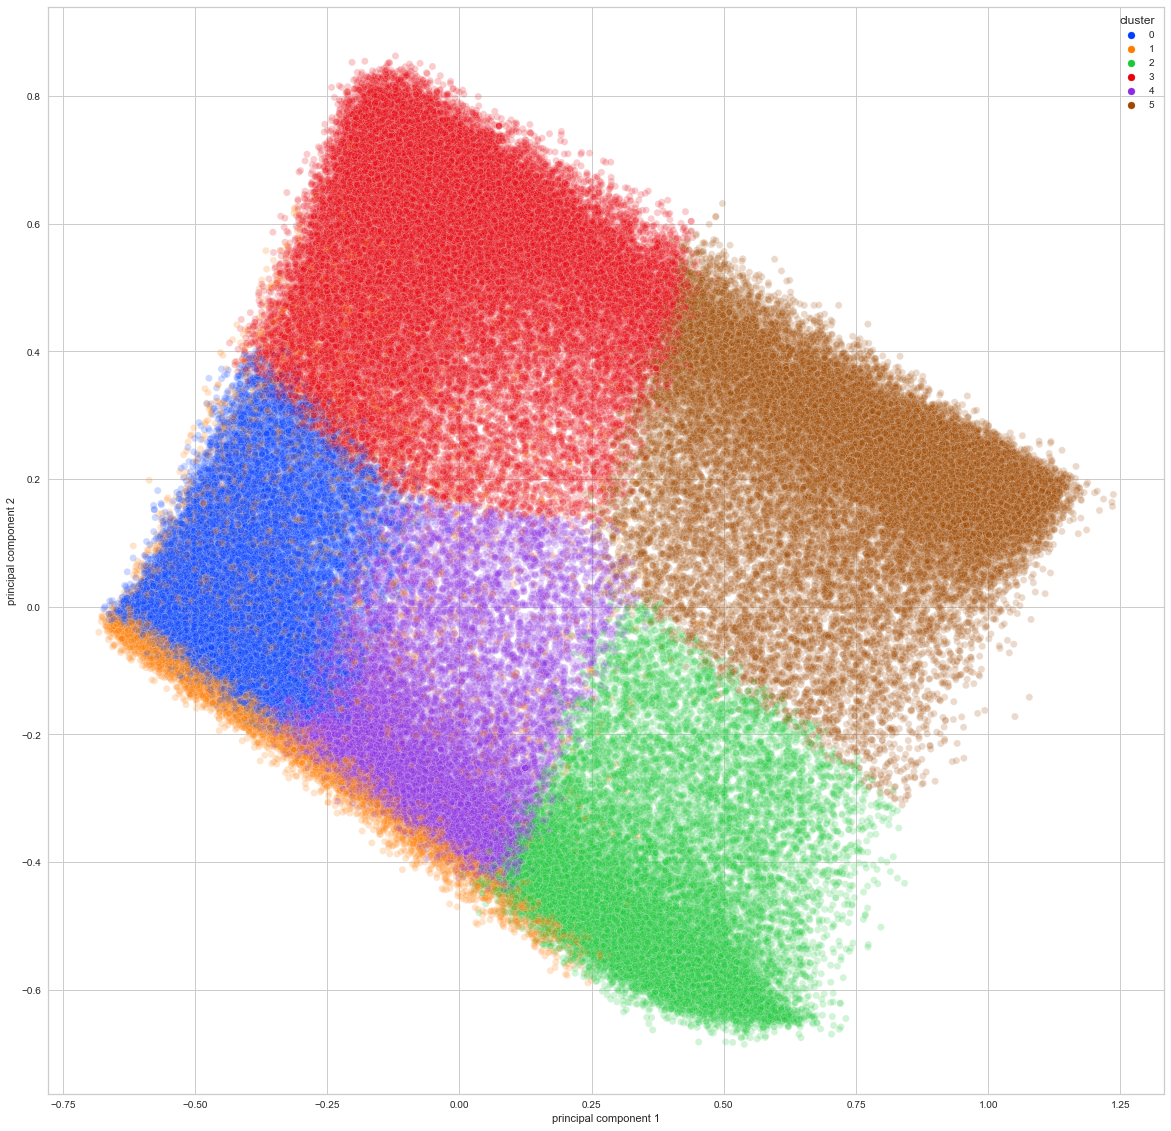

In [91]:
plt.figure(figsize=(20,20))
sns.scatterplot(x=principalDf['principal component 1'],
                y=principalDf['principal component 2'],
                hue=principalDf['cluster'],
                alpha=0.2,
                x_jitter=0.5,
                y_jitter=0.5,
                #marker='+',
                palette='bright')
plt.show()

In [99]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents3D = pca.fit_transform(df_train_trans)
principalDf3D = pd.DataFrame(data = principalComponents3D, columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf3D['cluster'] = kmeans.labels_
principalDf3D

,principal component 1,principal component 2,principal component 3,cluster
0,-0.081491,-0.342698,0.116033,4
1,-0.368693,-0.109463,-0.104864,0
2,-0.247076,-0.130538,0.256518,1
3,0.525332,-0.247023,-0.135127,2
4,0.872698,0.288046,-0.105871,5
...,...,...,...,...
232961,-0.547875,-0.002934,-0.148158,0
232962,-0.211810,0.043161,0.070675,0
232963,-0.404159,-0.084244,-0.048005,0
232964,-0.058250,0.448530,0.020854,3


<IPython.core.display.Javascript object>


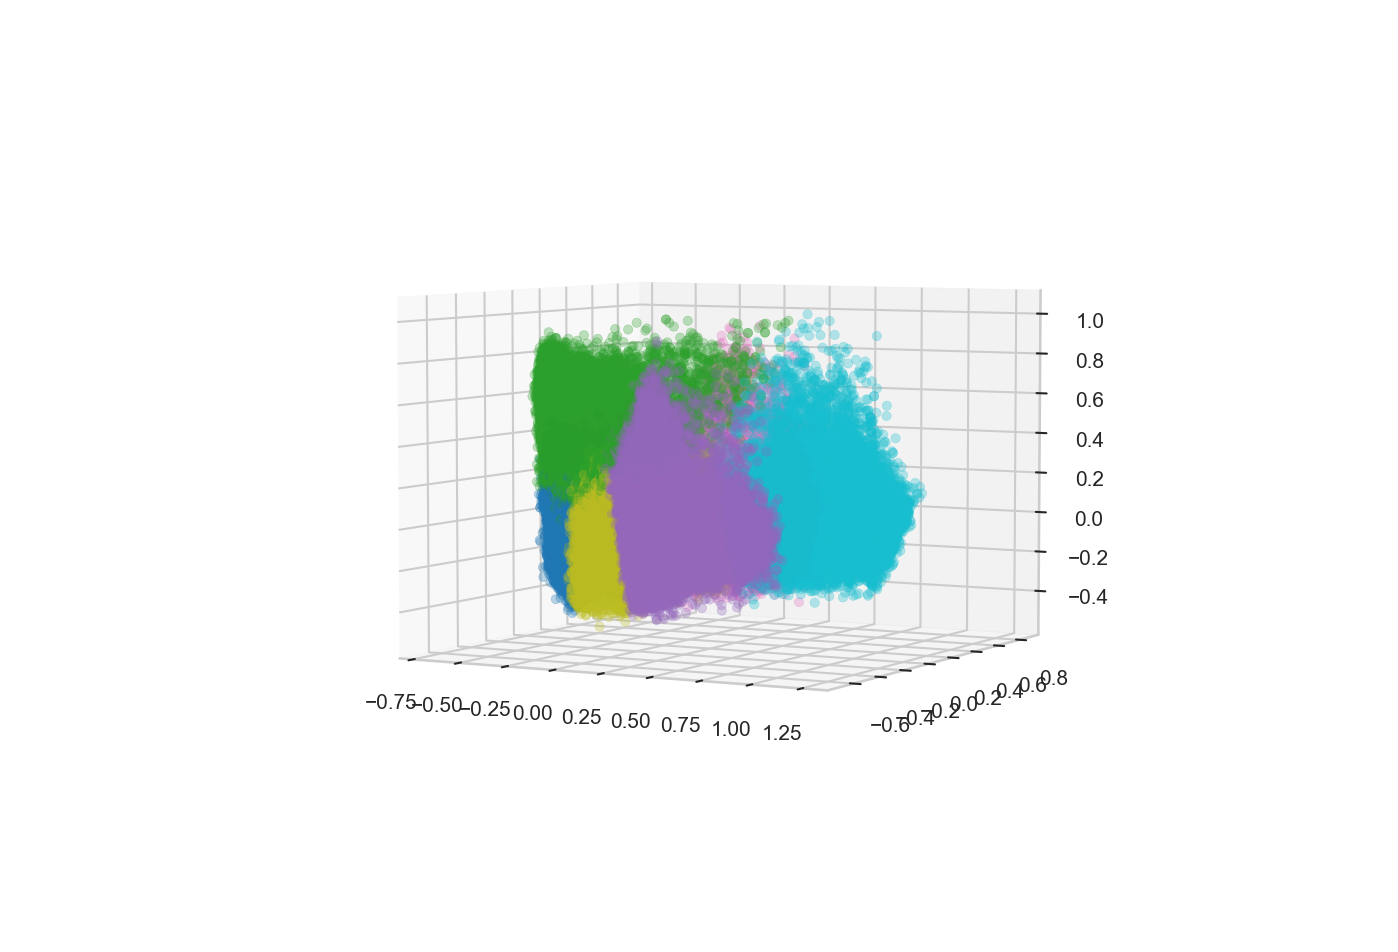

In [180]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(principalDf['principal component 1'], 
           principalDf['principal component 2'], 
           principalDf['principal component 3'], 
           c=principalDf['cluster'],
           cmap='tab10',
           alpha = 0.3)

for ii in range(0,360,30):

    ax.view_init(elev=10., azim=ii)
    plt.savefig("movie%d.png" % ii)